# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

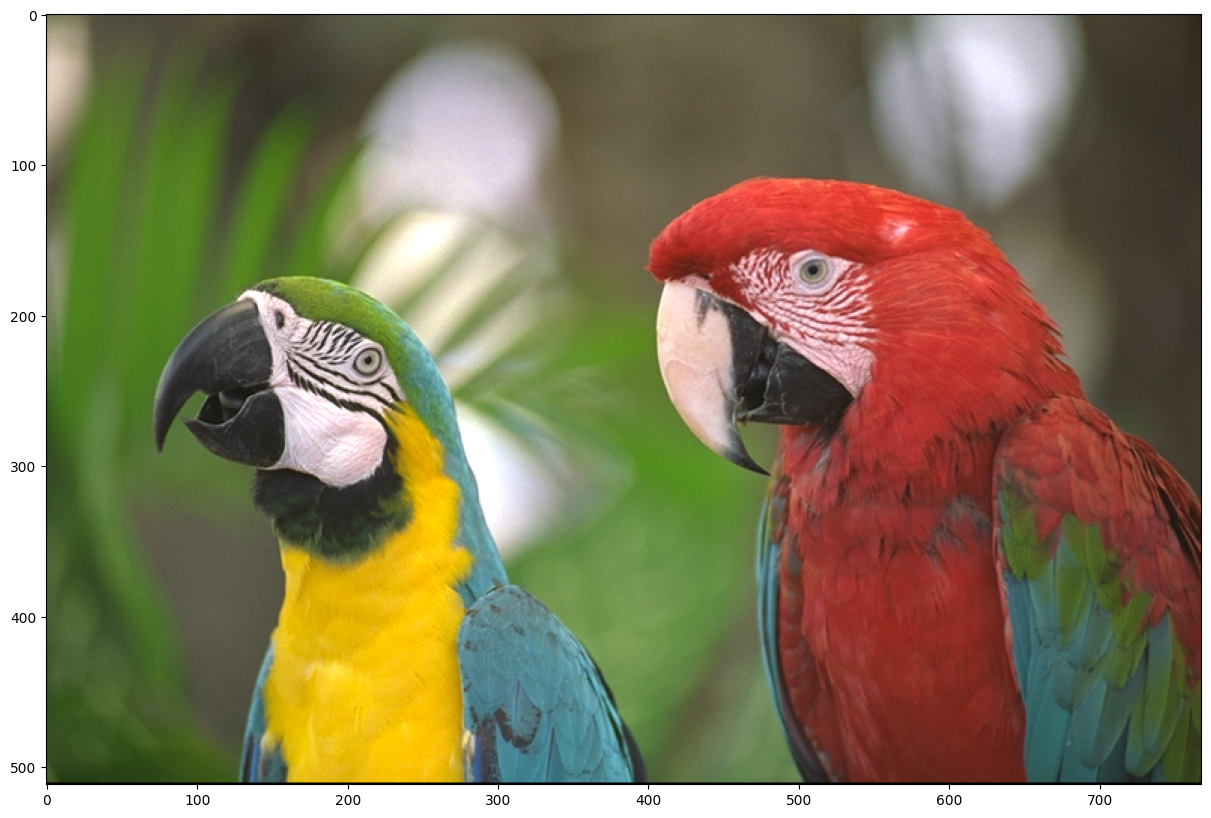

In [5]:
# Load image
img = cv2.imread('../data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [6]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [8]:
# Cast the image to float
img.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Определение палитры (например, базовые цвета)
palette = np.array([
    [0, 0, 0],       # черный
    [255, 255, 255], # белый
    [255, 0, 0],     # красный
    [0, 255, 0],     # зеленый
    [0, 0, 255],     # синий
], dtype=np.float32)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.linalg.norm(palette - pixel, axis=1)
        new_pixel = palette[np.argmin(distances)] 
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

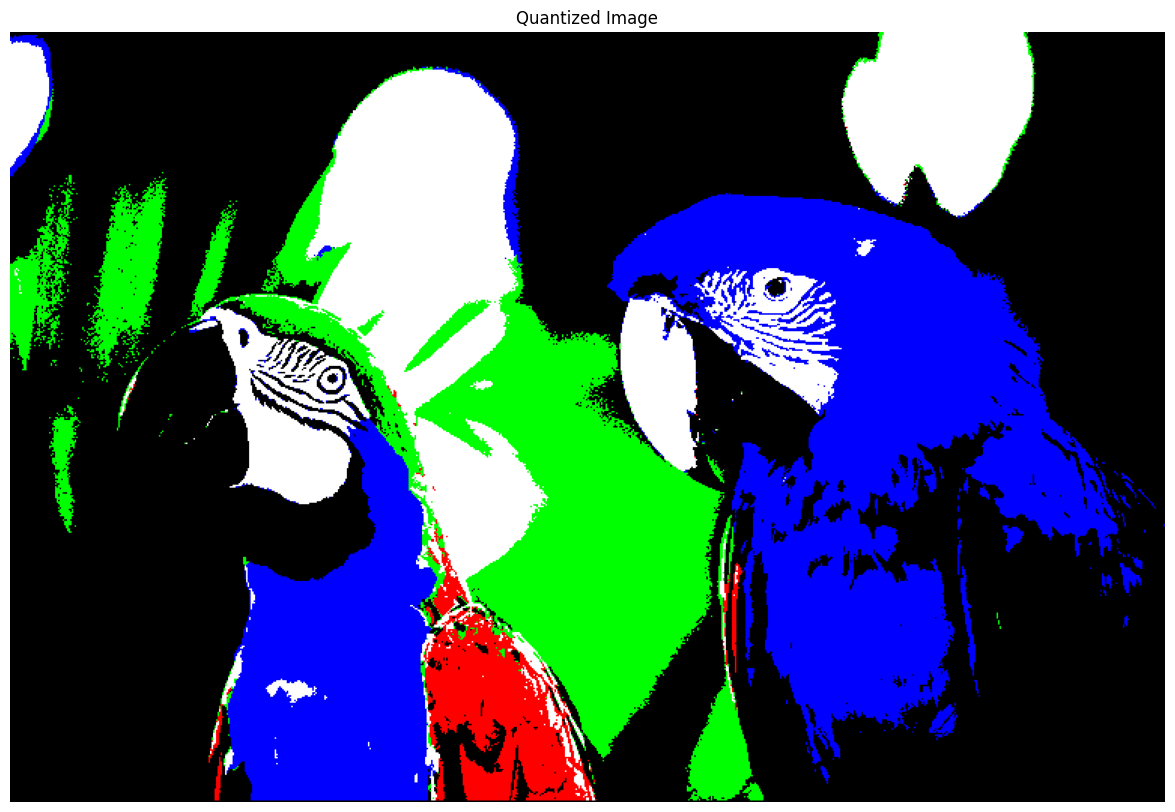

In [10]:
# Show quantized image (don't forget to cast back to uint8)
# Преобразование результата обратно в целые числа для отображения
quantized_uint8 = quantized.astype(np.uint8)
plt.imshow(cv2.cvtColor(quantized_uint8, cv2.COLOR_BGR2RGB))
plt.title('Quantized Image')
plt.axis('off')
plt.show()

In [12]:
# Compute average quantization error
quant_error = np.linalg.norm(img - quantized) / (rows * cols * channels)
avg_quant_error = quant_error

print("Средняя ошибка квантования:", avg_quant_error)

Средняя ошибка квантования: 0.10602166178428696


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [15]:
# Make a temporal copy of the original image, we will need it for error diffusion

img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.linalg.norm(palette - pixel, axis=1)
        new_pixel = palette[np.argmin(distances)]        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        # img_tmp =
        img_tmp[r, c, :] = new_pixel
        img_tmp[r, c + 1, :] += (quant_error * 7 / 16).astype(np.uint8)
        img_tmp[r + 1, c - 1, :] += (quant_error * 3 / 16).astype(np.uint8)
        img_tmp[r + 1, c, :] += (quant_error * 5 / 16).astype(np.uint8)
        img_tmp[r + 1, c + 1, :] += (quant_error * 1 / 16).astype(np.uint8)

        
        # Apply dithering
        dithering[r, c, :] = new_pixel

Text(0.5, 1.0, 'Dithering')

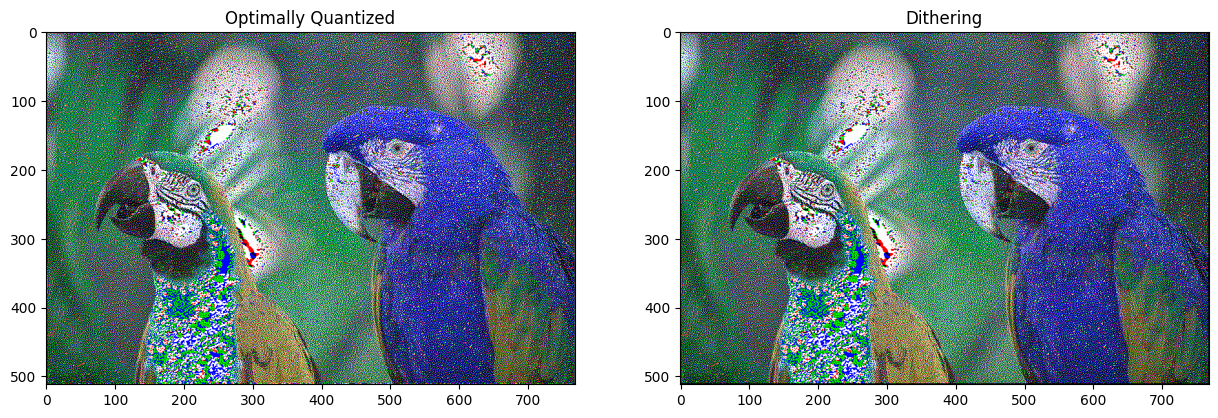

In [18]:
# Show quantized image (don't forget to cast back to uint8)
# Преобразовать изображения к типу uint8
img_quantized = img_tmp.astype(np.uint8)
dithering = dithering.astype(np.uint8)

plt.subplot(121), plt.imshow(cv2.cvtColor(img_quantized, cv2.COLOR_BGR2RGB))   # optimally quantized
plt.title('Optimally Quantized')
plt.subplot(122), plt.imshow(cv2.cvtColor(dithering, cv2.COLOR_BGR2RGB))   # dithering
plt.title('Dithering')

In [19]:
# Compute average quantization error for dithered image
diff_dith = np.abs(img - dithering)  # вычисляем абсолютное значение разницы между исходным и дизерингированным изображениями
avg_dith_error = np.mean(diff_dith)  # вычисляем среднее значение этой разницы
print("Average quantization error for dithered image:", avg_dith_error)

Average quantization error for dithered image: 101.0116721259223


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

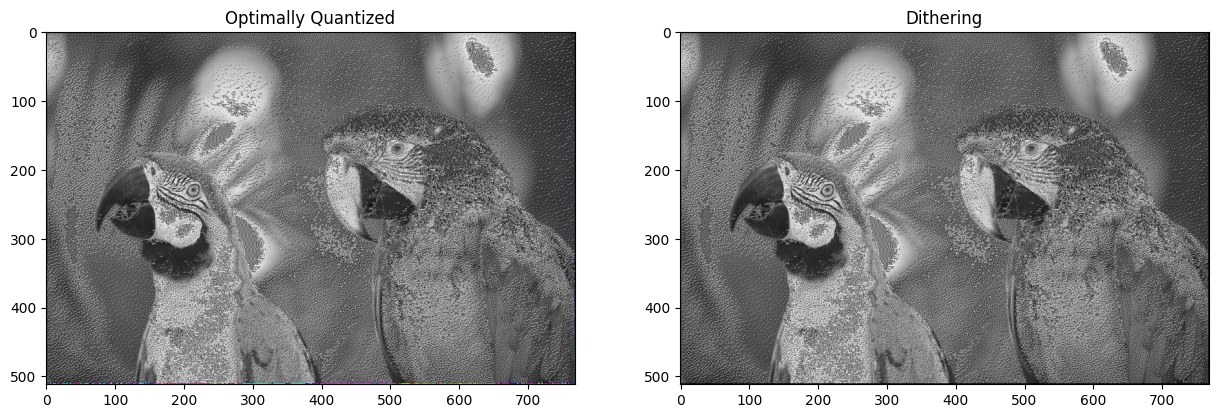

In [22]:
# Apply Floyd-Steinberg dithering with the new color palette
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c, :]
        distances = np.linalg.norm(colors - pixel, axis=1)
        new_pixel = colors[np.argmin(distances)]        

        quant_error = pixel - new_pixel

        img_tmp[r, c, :] = new_pixel
        img_tmp[r, c + 1, :] += (quant_error * 7 / 16).astype(np.uint8)
        img_tmp[r + 1, c - 1, :] += (quant_error * 3 / 16).astype(np.uint8)
        img_tmp[r + 1, c, :] += (quant_error * 5 / 16).astype(np.uint8)
        img_tmp[r + 1, c + 1, :] += (quant_error * 1 / 16).astype(np.uint8)

        dithering[r, c, :] = new_pixel

# Convert images to uint8 for display
img_quantized = img_tmp.astype(np.uint8)
dithering = dithering.astype(np.uint8)

# Display the images
plt.subplot(121), plt.imshow(cv2.cvtColor(img_quantized, cv2.COLOR_BGR2RGB))   # quantized image
plt.title('Optimally Quantized')
plt.subplot(122), plt.imshow(cv2.cvtColor(dithering, cv2.COLOR_BGR2RGB))   # dithering
plt.title('Dithering')
plt.show()

Apply FS dithering the same way you did before.
* How does the result look like to you?
*       цветовая палитра будет другой, поскольку теперь она основана на 
*       цветах, полученных с помощью алгоритма кластеризации k-средних.
* What happens if we use 32 colours?
*       приведет к более плавному изображению с менее заметными артефактами 
*       квантования по сравнению с использованием только 16 цветов
* And what happens if we use 256 colours?
*       Использование 256 цветов обеспечит еще больше вариаций цвета и
 *      детализации, что приведет к получению изображения более высокого 
  *     качества с меньшим количеством видимых артефактов.